In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array



In [14]:
# Définition de la taille des images d'entrée du modèle (128x128 pixels)
image_size = (128, 128)
batch_size = 32
epochs = 50

# Définition du répertoire des données d'entraînement
train_dir = "Players_merged1"


# Initialisation du générateur d'images avec des transformations (augmentation)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Générateur d'images d'entraînement
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# # Générateur d'images de validation
# validation_generator = datagen.flow_from_directory(
#     val_dir,
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=False
# )


Found 1119 images belonging to 461 classes.


In [15]:
# Charger MobileNetV2 comme modèle de base
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Construction du modèle complet
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])




Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - accuracy: 0.0042 - loss: 6.3464
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.0040 - loss: 6.1242
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.0027 - loss: 6.0943
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - accuracy: 0.0087 - loss: 6.0510
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 286ms/step - accuracy: 0.0104 - loss: 5.9452
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 346ms/step - accuracy: 0.0237 - loss: 5.8177
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - accuracy: 0.0154 - loss: 5.7624
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - accuracy: 0.0341 - loss: 5.5677
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - accuracy: 0.0467 - loss: 5.4096
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.0597 - loss: 5.3003
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 269ms/step - accuracy: 0.0808 - loss: 5.0750
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 293ms

KeyError: 'val_accuracy'

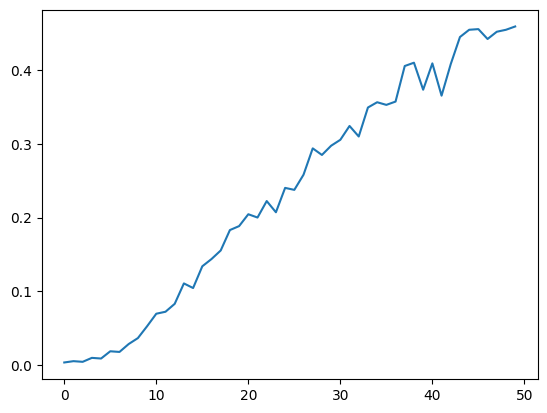

In [ ]:
# Entraînement du modèle
history = model.fit(
    train_generator,
    # validation_data=validation_generator,
    epochs=epochs
)

# Courbe de précision
plt.plot(history.history['accuracy'], label='Précision Entraînement')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.show()

# Courbe de perte
plt.plot(history.history['loss'], label='Perte Entraînement')
plt.plot(history.history['val_loss'], label='Perte Validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.show()

# Fonction pour capturer une image
def capture_image():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Erreur : impossible d'accéder à la caméra")
        return None
    
    ret, frame = cap.read()
    cap.release()
    
    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        plt.title("Image Capturée")
        plt.axis('off')
        plt.show()
        
        img = cv2.resize(frame, (128, 128))
        img = img_to_array(img) / 255.0
        img = np.expand_dims(img, axis=0)
        return frame, img
    else:
        print("Erreur lors de la capture de l'image")
        return None, None


In [17]:
# Sauvegarde du modèle
model.save("modelfinal.h5")

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

# Fonction de prédiction de ressemblance
def predict_ressemblance(model, image, frame, data_dir, train_generator):
    # Prédiction du modèle
    predictions = model.predict(image)[0]
    class_names = list(train_generator.class_indices.keys())

    # Trier les probabilités par ordre décroissant
    sorted_predictions = sorted(zip(class_names, predictions), key=lambda x: x[1], reverse=True)
    top_5_predictions = sorted_predictions[:5]

    print("Top 5 joueurs ressemblants :")
    for class_name, prob in top_5_predictions:
        print(f"{class_name}: {prob * 100:.2f}%")

    # Joueur prédit (le plus probable)
    predicted_player = top_5_predictions[0][0]
    player_path = os.path.join(data_dir, predicted_player)

    if not os.path.exists(player_path):
        print(f"Erreur : dossier du joueur {predicted_player} introuvable.")
        return

    # Charger une image du joueur prédit pour l'afficher
    player_images = [img for img in os.listdir(player_path) if img.endswith(('.jpg', '.png', '.jpeg'))]
    
    if not player_images:
        print(f"Aucune image trouvée pour le joueur {predicted_player}.")
        return

    best_match_image_path = os.path.join(player_path, player_images[0])
    best_match_image = cv2.imread(best_match_image_path)

    if best_match_image is None:
        print(f"Erreur de chargement de l'image du joueur : {best_match_image_path}")
        return

    # Affichage de l'image capturée et de la meilleure correspondance
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title("Image Capturée")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(best_match_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Ressemblance : {predicted_player} ({top_5_predictions[0][1] * 100:.2f}%)")
    plt.axis('off')
    plt.show()

# Capture d'image depuis la webcam
def capture_image():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Erreur : impossible d'accéder à la caméra")
        return None, None

    ret, frame = cap.read()
    cap.release()

    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        plt.title("Image Capturée")
        plt.axis('off')
        plt.show()

        img = cv2.resize(frame, (128, 128))
        img = img_to_array(img) / 255.0
        img = np.expand_dims(img, axis=0)
        return frame, img
    else:
        print("Erreur lors de la capture de l'image")
        return None, None

# Charger le modèle entraîné
model = tf.keras.models.load_model('modelfinal.h5')

# Définition du répertoire des données d'entraînement
data_dir = "Players_merged1"

# Générateur d'images pour accéder aux classes
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Capture d'une image et prédiction
frame, image = capture_image()

if image is not None:
    predict_ressemblance(model, image, frame, data_dir, train_generator)
